In [1]:
import os
from tqdm.autonotebook import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  


In [2]:
import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnext50_32x4d', pretrained=True)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth


  0%|          | 0.00/95.8M [00:00<?, ?B/s]

In [ ]:
model

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
ls data

ls: cannot access 'data': No such file or directory


In [18]:

data_transforms = {
    'train': transforms.Compose([
        # transforms.RandomResizedCrop(244),
        # transforms.RandomHorizontalFlip(),
        
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        # transforms.CenterCrop(244),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),

        'test': transforms.Compose([
        transforms.Resize(256),
        # transforms.CenterCrop(244),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'gdrive/My Drive/data_prep'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=2)
               for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

In [19]:
print(dataset_sizes)

{'train': 6692, 'val': 2593, 'test': 1041}


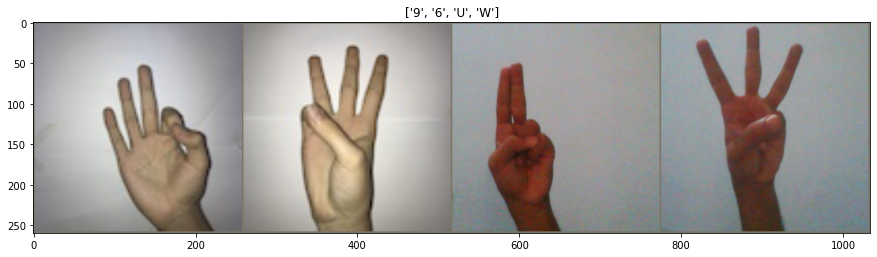

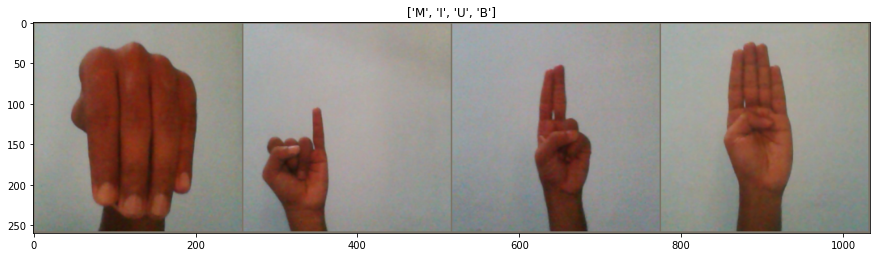

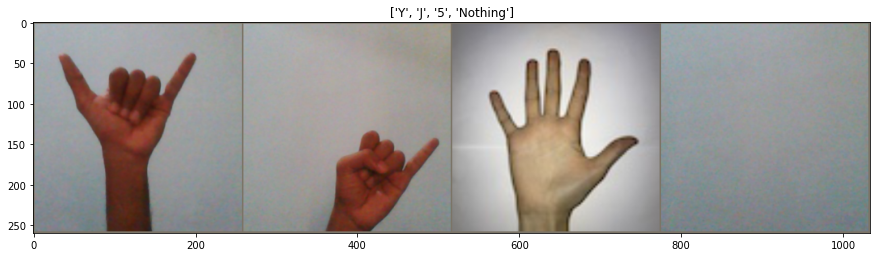

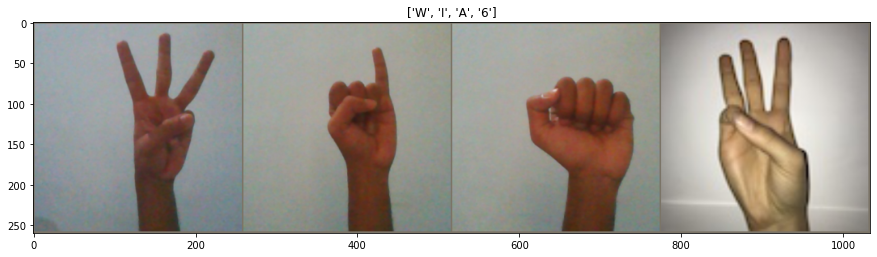

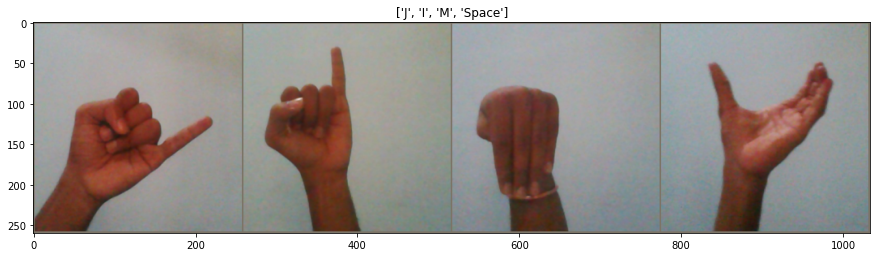

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(15, 12))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


for _ in range(5):
  inputs, classes = next(iter(dataloaders['train']))

  out = torchvision.utils.make_grid(inputs)

  imshow(out, title=[class_names[x] for x in classes])

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    losses = {'train': [], "val": []}
    accs = {'train': [], "val": []}

    pbar = trange(num_epochs, desc="Epoch:")

    for epoch in pbar:

        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # установим модель в режим обучения
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # итерируемся по батчам
            for data in tqdm(dataloaders[phase], leave=False, desc=f"{phase} iter:"):
                # получаем картинки и метки
                inputs, labels = data

                if use_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()
                else:
                    inputs, labels = inputs, labels

                # инициализируем градиенты параметров
                if phase=="train":
                    optimizer.zero_grad()

                # forward pass
                if phase == "eval":
                    with torch.no_grad():
                        outputs = model(inputs)
                else:
                    outputs = model(inputs)
                preds = torch.argmax(outputs, -1)
                loss = criterion(outputs, labels)

                # backward pass, оптимизируем только если это стадия обучения
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # считаем лоссы
                running_loss += loss.item()
                running_corrects += int(torch.sum(preds == labels.data))

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            losses[phase].append(epoch_loss)
            accs[phase].append(epoch_acc)
            
            pbar.set_description('{} Loss: {:.4f} Acc: {:.4f}'.format(
                                    phase, epoch_loss, epoch_acc
                                ))

            # если достиглось лучшее качество, то запомним веса модели
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # загрузим лучшие веса модели
    model.load_state_dict(best_model_wts)
    return model, losses, accs

In [60]:
def visualize_model(model, num_batches=6):
  for _ in range(num_batches):
    inputs, classes = next(iter(dataloaders['val']))
    out = torchvision.utils.make_grid(inputs)
    inputs = inputs.cuda()
    outputs = model(inputs)
    _, preds = torch.max(outputs.data, 1)

    label_dict = {
        0:'0',
        1:'1',
        2:'2',
        3:'3',
        4:'4',
        5:'5',
        6:'6',
        7:'7',
        8:'8',
        9:'9',
        10:'A',
        11:'B',
        12:'C',
        13:'D',
        14:'E',
        15:'F',
        16:'J',
        17:'H',
        18:'I',
        19:'J',
        20:'K',
        21:'L',
        22:'M',
        23:'N',
        24:'Nothing',
        25:'O',
        26:'P',
        27:'Q',
        28:'R',
        29:'S',
        30:'Space',
        31:'T',
        32:'U',
        33:'V',
        34:'W',
        35:'X',
        36:'Y',
        37:'Z'
  
    }


    # if str(preds.cpu().numpy())!=str([class_names[x] for x in classes]).replace(',','').replace("'",''):
    title='         real:' + str([class_names[x] for x in classes]) + '\npredicted:' + str([label_dict[int(x)] for x in (preds.cpu().numpy())])

    imshow(out, title=title)

In [11]:
def evaluate(model):
    model.eval()
    
    runninig_correct = 0
    for data in dataloaders['val']:
        # получаем картинки и метки
        inputs, labels = data
        
        # переносим на gpu, если возможно
        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()
            
        # forard pass
        output = model(inputs)
        _, predicted = torch.max(output, 1)
        
        runninig_correct += int(torch.sum(predicted == labels))
        
    return runninig_correct / dataset_sizes['val']

* **Fine Tuning** способ

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnext50_32x4d', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# num_features - размерность вектора фич, поступающего на вход FC-слою
num_features = 2048
# Заменяем Fully-Connected слой на линейный классификатор
model.fc = nn.Linear(num_features, 38)

# Использовать ли GPU
if use_gpu:
    model = model.cuda()

loss_fn = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model.parameters(), lr=1e-4)

# Умножаем learning_rate на 0.1 каждые 7 эпох 
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model

In [ ]:
%%time
model, losses, accs = train_model(model, loss_fn, optimizer_ft, exp_lr_scheduler, num_epochs=3)

Epoch::   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train iter::   0%|          | 0/1673 [00:00<?, ?it/s]

val iter::   0%|          | 0/649 [00:00<?, ?it/s]

train iter::   0%|          | 0/1673 [00:00<?, ?it/s]

val iter::   0%|          | 0/649 [00:00<?, ?it/s]

train iter::   0%|          | 0/1673 [00:00<?, ?it/s]

val iter::   0%|          | 0/649 [00:00<?, ?it/s]

Training complete in 26m 56s
Best val Acc: 0.999229
CPU times: user 7min 10s, sys: 1min 11s, total: 8min 21s
Wall time: 26min 56s


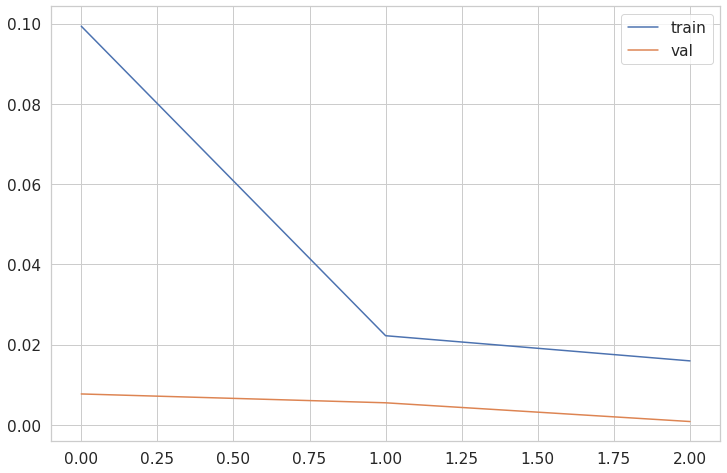

In [ ]:
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.4)

# Построим график лосса при обучении и валидации

plt.figure(figsize=(12, 8))
plt.plot(losses['train'], label="train")
plt.plot(losses['val'], label="val")
plt.legend()
plt.show()

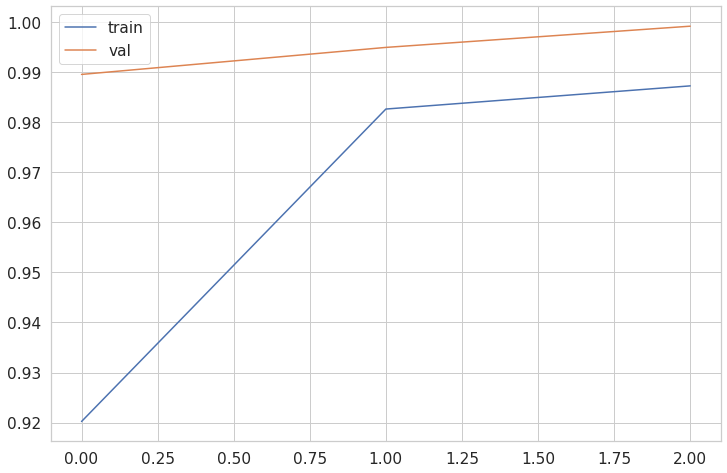

In [ ]:
sns.set(style="whitegrid", font_scale=1.4)


plt.figure(figsize=(12, 8))
plt.plot(accs['train'], label="train")
plt.plot(accs['val'], label="val")
plt.legend()
plt.show()

In [ ]:
print("Accuracy: {0:.4f}".format(evaluate(model)))

Accuracy: 0.9992


* **Feature Extractor** способ:

In [42]:
model_extractor = torch.hub.load('pytorch/vision:v0.10.0', 'resnext50_32x4d', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [43]:
for param in model_extractor.parameters():
    print(param.requires_grad)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [45]:
# замораживаем параметры (веса)
for param in model_extractor.parameters():
    param.requires_grad = False

# num_features - это размерность вектора фич, поступающего на вход FC-слою
num_features = 2048

# Заменяем Fully-Connected слой на наш линейный классификатор
model_extractor.fc = nn.Linear(num_features, 38)

if use_gpu:
    model_extractor = model_extractor.cuda()

loss_fn = nn.CrossEntropyLoss()

optimizer = optim.Adam(model_extractor.fc.parameters(), lr=1e-4)

# # Умножим learning_rate на 0.1 каждые 5 эпох
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [46]:
%%time
model_extractor,losses, accs = train_model(model_extractor, loss_fn, optimizer, exp_lr_scheduler, num_epochs=7)

Epoch::   0%|          | 0/7 [00:00<?, ?it/s]

train iter::   0%|          | 0/1673 [00:00<?, ?it/s]

val iter::   0%|          | 0/649 [00:00<?, ?it/s]

train iter::   0%|          | 0/1673 [00:00<?, ?it/s]

val iter::   0%|          | 0/649 [00:00<?, ?it/s]

train iter::   0%|          | 0/1673 [00:00<?, ?it/s]

val iter::   0%|          | 0/649 [00:00<?, ?it/s]

train iter::   0%|          | 0/1673 [00:00<?, ?it/s]

val iter::   0%|          | 0/649 [00:00<?, ?it/s]

train iter::   0%|          | 0/1673 [00:00<?, ?it/s]

val iter::   0%|          | 0/649 [00:00<?, ?it/s]

train iter::   0%|          | 0/1673 [00:00<?, ?it/s]

val iter::   0%|          | 0/649 [00:00<?, ?it/s]

train iter::   0%|          | 0/1673 [00:00<?, ?it/s]

val iter::   0%|          | 0/649 [00:00<?, ?it/s]

Training complete in 10m 33s
Best val Acc: 0.939067
CPU times: user 6min 12s, sys: 26.5 s, total: 6min 39s
Wall time: 10min 32s


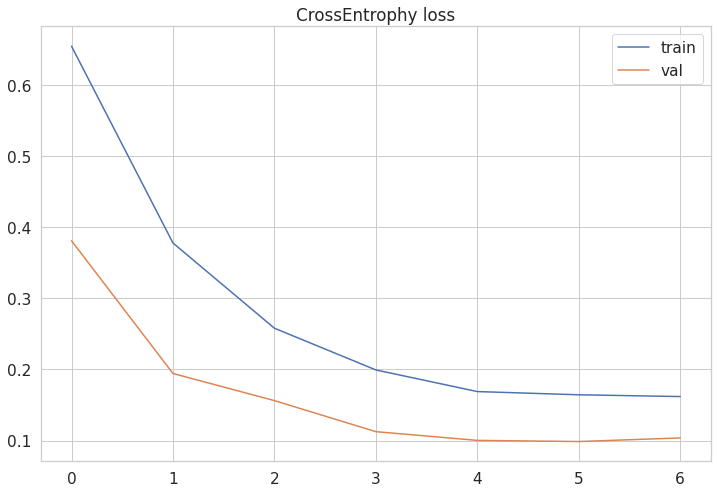

In [53]:
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.4)

plt.figure(figsize=(12, 8))
plt.plot(losses['train'], label="train")
plt.plot(losses['val'], label="val")
plt.title('CrossEntrophy loss')
plt.legend()
plt.show()

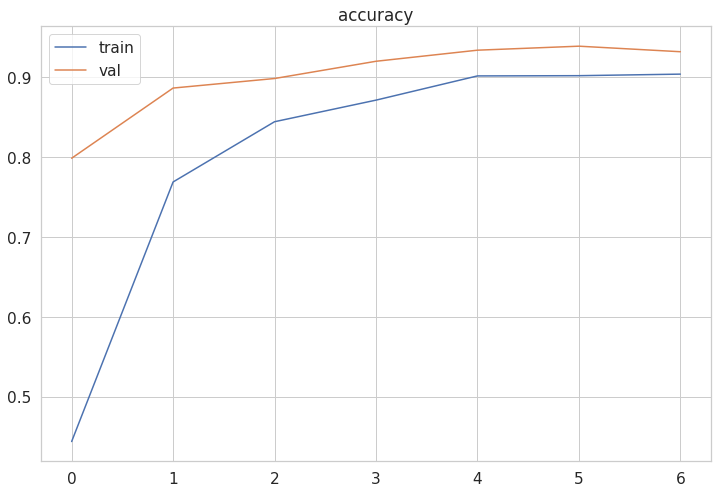

In [54]:
sns.set(style="whitegrid", font_scale=1.4)


plt.figure(figsize=(12, 8))
plt.plot(accs['train'], label="train")
plt.plot(accs['val'], label="val")
plt.title('accuracy')
plt.legend()
plt.show()

In [49]:
print("Accuracy: {0:.4f}".format(evaluate(model_extractor)))

Accuracy: 0.9321


* **Смешанный** способ:
Мы будем обучать не только последний **fully connected** слой, но и один предпоследних

In [20]:
model_mixed = torch.hub.load('pytorch/vision:v0.10.0', 'resnext50_32x4d', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [21]:
model_mixed.parameters

<bound method Module.parameters of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        

In [25]:
# Выключаем подсчет градиентов для слоев, которые не будем обучать
for param in model_mixed.parameters():
    param.requires_grad = False

# model_mixed.layer1.requires_grad = False
# model_mixed.layer2.requires_grad = False
# model_mixed.layer3.requires_grad = False
model_mixed.layer4.requires_grad = True
    
# num_features - это размерность вектора фич, поступающего на вход FC-слою
num_features = 2048

# Заменяем Fully-Connected слой на линейный классификатор
model_mixed.fc = nn.Linear(num_features, 38)

# Использовать ли GPU
if use_gpu:
    model_mixed = model_mixed.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# Обучаем последний слой из сверточной части и fully connected слой 
optimizer = optim.Adam(list(model_mixed.fc.parameters()) + list(model_mixed.layer4.parameters()), lr=1e-4)

# Умножим learning_rate на 0.1 каждые 7 эпох
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [26]:
%%time
model_mixed, losses, accs = train_model(model_mixed, loss_fn, optimizer, exp_lr_scheduler, num_epochs=10)

Epoch::   0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train iter::   0%|          | 0/1673 [00:00<?, ?it/s]

val iter::   0%|          | 0/649 [00:00<?, ?it/s]

train iter::   0%|          | 0/1673 [00:00<?, ?it/s]

val iter::   0%|          | 0/649 [00:00<?, ?it/s]

train iter::   0%|          | 0/1673 [00:00<?, ?it/s]

val iter::   0%|          | 0/649 [00:00<?, ?it/s]

train iter::   0%|          | 0/1673 [00:00<?, ?it/s]

val iter::   0%|          | 0/649 [00:00<?, ?it/s]

train iter::   0%|          | 0/1673 [00:00<?, ?it/s]

val iter::   0%|          | 0/649 [00:00<?, ?it/s]

train iter::   0%|          | 0/1673 [00:00<?, ?it/s]

val iter::   0%|          | 0/649 [00:00<?, ?it/s]

train iter::   0%|          | 0/1673 [00:00<?, ?it/s]

val iter::   0%|          | 0/649 [00:00<?, ?it/s]

train iter::   0%|          | 0/1673 [00:00<?, ?it/s]

val iter::   0%|          | 0/649 [00:00<?, ?it/s]

train iter::   0%|          | 0/1673 [00:00<?, ?it/s]

val iter::   0%|          | 0/649 [00:00<?, ?it/s]

train iter::   0%|          | 0/1673 [00:00<?, ?it/s]

val iter::   0%|          | 0/649 [00:00<?, ?it/s]

Training complete in 23m 6s
Best val Acc: 0.943309
CPU times: user 9min 8s, sys: 37.8 s, total: 9min 46s
Wall time: 23min 5s


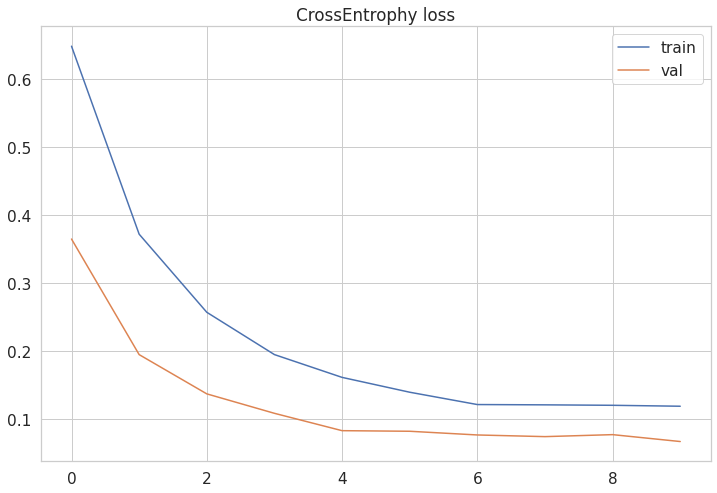

In [30]:
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.4)

# Построим график лосса при обучении и валидации

plt.figure(figsize=(12, 8))
plt.plot(losses['train'], label="train")
plt.plot(losses['val'], label="val")
plt.title('CrossEntrophy loss')
plt.legend()
plt.show()

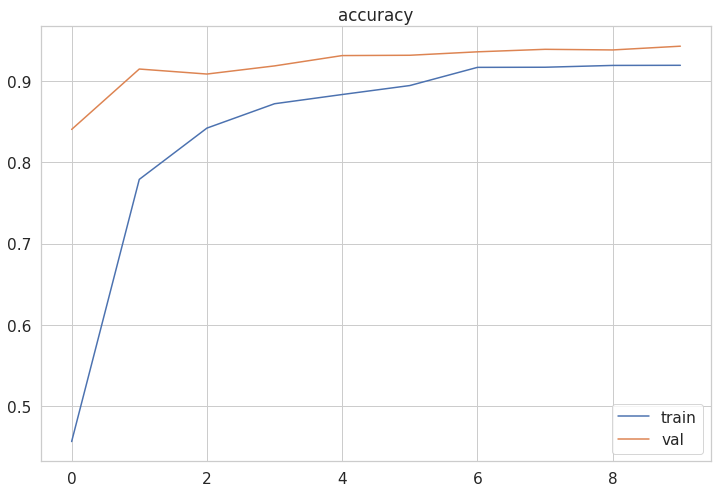

In [31]:
sns.set(style="whitegrid", font_scale=1.4)

plt.figure(figsize=(12, 8))
plt.plot(accs['train'], label="train")
plt.plot(accs['val'], label="val")
plt.title('accuracy')
plt.legend()
plt.show()

In [29]:
print("Accuracy: {0:.4f}".format(evaluate(model_mixed)))

Accuracy: 0.9433


* **Еще один** способ: можно не замораживать все первые слои, а делать так, чтобы шаг градиента на них был меньше. Интерфейс оптимизатора позволяет это делать

In [32]:
model_diff_lr = torch.hub.load('pytorch/vision:v0.10.0', 'resnext50_32x4d', pretrained=True)
num_features = 2048
model_diff_lr.fc = nn.Linear(num_features, 38)


optimizer = torch.optim.Adam(params=[
        {"params": model_diff_lr.fc.parameters()},
        {"params": model_diff_lr.layer4.parameters(), "lr": 1e-5,}
    ], 
    lr=1e-4
)

if use_gpu:
    model_diff_lr = model_diff_lr.cuda()

loss_fn = nn.CrossEntropyLoss()


# Умножаем learning_rate на 0.1 каждые 7 эпох 
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [37]:
%%time
model_diff_lr, losses, accs = train_model(model_diff_lr, loss_fn, optimizer, exp_lr_scheduler, num_epochs=15)

Epoch::   0%|          | 0/15 [00:00<?, ?it/s]

train iter::   0%|          | 0/1673 [00:00<?, ?it/s]

val iter::   0%|          | 0/649 [00:00<?, ?it/s]

train iter::   0%|          | 0/1673 [00:00<?, ?it/s]

val iter::   0%|          | 0/649 [00:00<?, ?it/s]

train iter::   0%|          | 0/1673 [00:00<?, ?it/s]

val iter::   0%|          | 0/649 [00:00<?, ?it/s]

train iter::   0%|          | 0/1673 [00:00<?, ?it/s]

val iter::   0%|          | 0/649 [00:00<?, ?it/s]

train iter::   0%|          | 0/1673 [00:00<?, ?it/s]

val iter::   0%|          | 0/649 [00:00<?, ?it/s]

train iter::   0%|          | 0/1673 [00:00<?, ?it/s]

val iter::   0%|          | 0/649 [00:00<?, ?it/s]

train iter::   0%|          | 0/1673 [00:00<?, ?it/s]

val iter::   0%|          | 0/649 [00:00<?, ?it/s]

train iter::   0%|          | 0/1673 [00:00<?, ?it/s]

val iter::   0%|          | 0/649 [00:00<?, ?it/s]

train iter::   0%|          | 0/1673 [00:00<?, ?it/s]

val iter::   0%|          | 0/649 [00:00<?, ?it/s]

train iter::   0%|          | 0/1673 [00:00<?, ?it/s]

val iter::   0%|          | 0/649 [00:00<?, ?it/s]

train iter::   0%|          | 0/1673 [00:00<?, ?it/s]

val iter::   0%|          | 0/649 [00:00<?, ?it/s]

train iter::   0%|          | 0/1673 [00:00<?, ?it/s]

val iter::   0%|          | 0/649 [00:00<?, ?it/s]

train iter::   0%|          | 0/1673 [00:00<?, ?it/s]

val iter::   0%|          | 0/649 [00:00<?, ?it/s]

train iter::   0%|          | 0/1673 [00:00<?, ?it/s]

val iter::   0%|          | 0/649 [00:00<?, ?it/s]

train iter::   0%|          | 0/1673 [00:00<?, ?it/s]

val iter::   0%|          | 0/649 [00:00<?, ?it/s]

Training complete in 44m 29s
Best val Acc: 0.998843
CPU times: user 38min 32s, sys: 1min 4s, total: 39min 37s
Wall time: 44min 29s


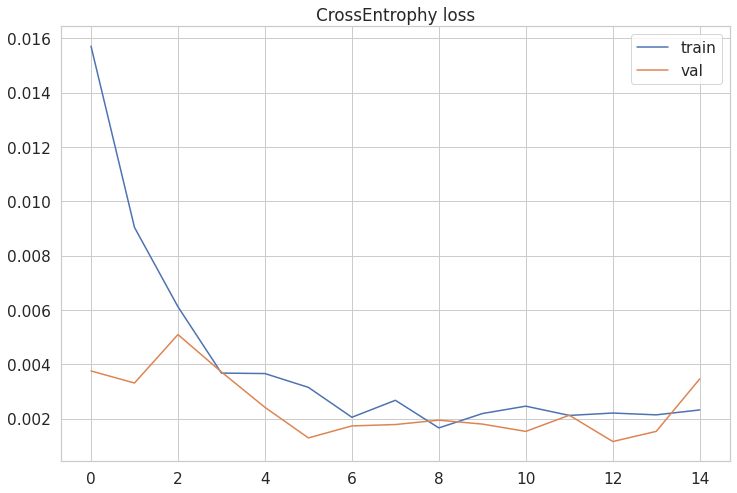

In [38]:
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.4)

# Построим график лосса при обучении и валидации

plt.figure(figsize=(12, 8))
plt.plot(losses['train'], label="train")
plt.plot(losses['val'], label="val")
plt.title('CrossEntrophy loss')
plt.legend()
plt.show()

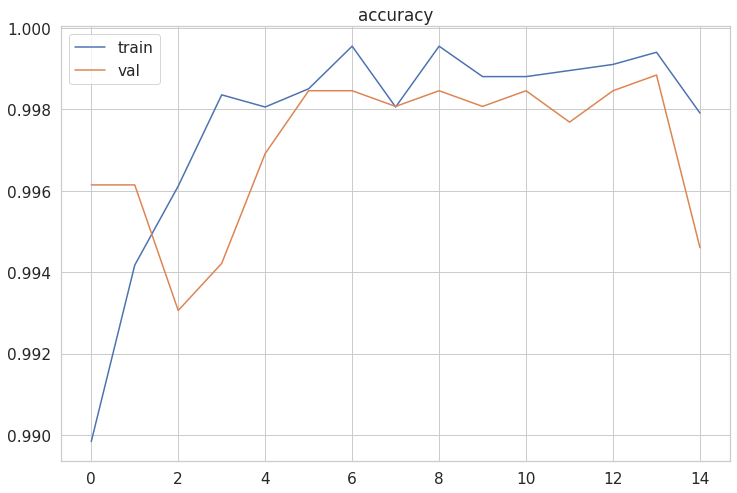

In [39]:
sns.set(style="whitegrid", font_scale=1.4)


plt.figure(figsize=(12, 8))
plt.plot(accs['train'], label="train")
plt.plot(accs['val'], label="val")
plt.title('accuracy')
plt.legend()
plt.show()

In [36]:
print("Accuracy: {0:.4f}".format(evaluate(model_diff_lr)))

Accuracy: 0.9853


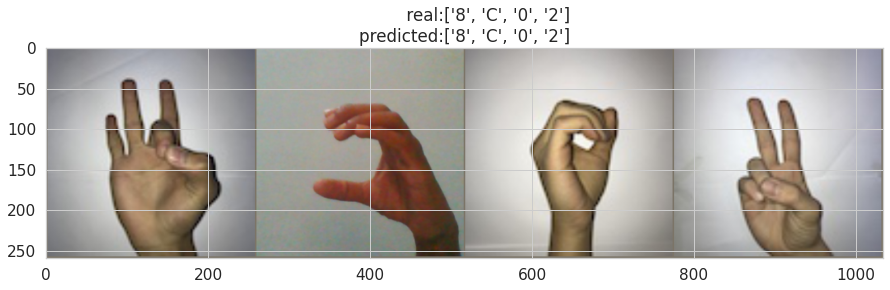

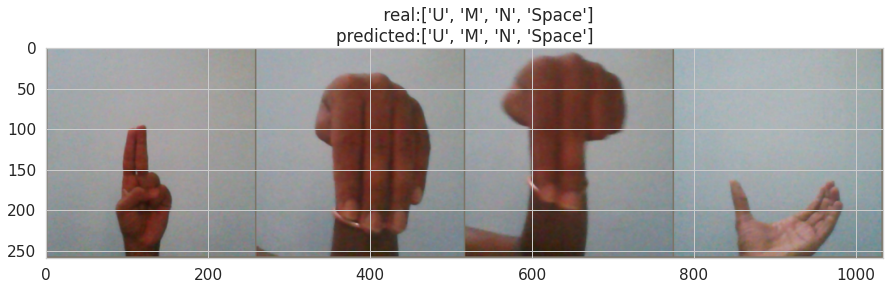

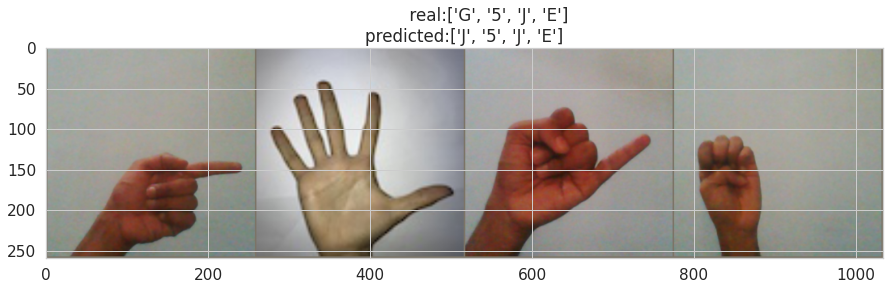

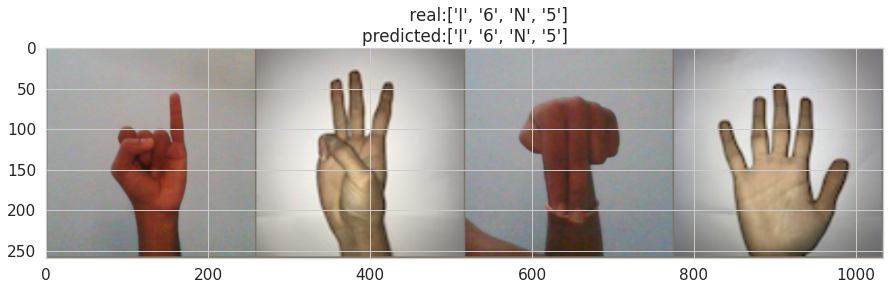

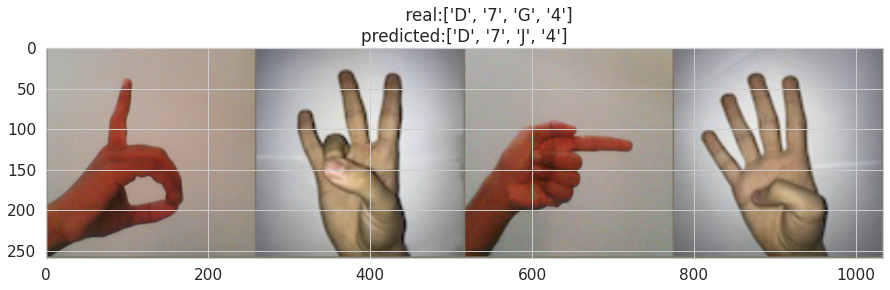

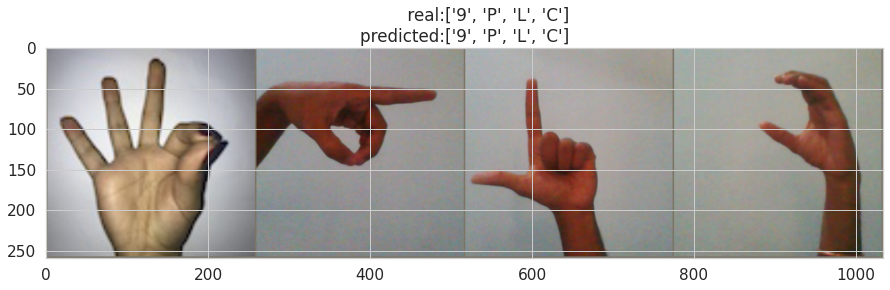

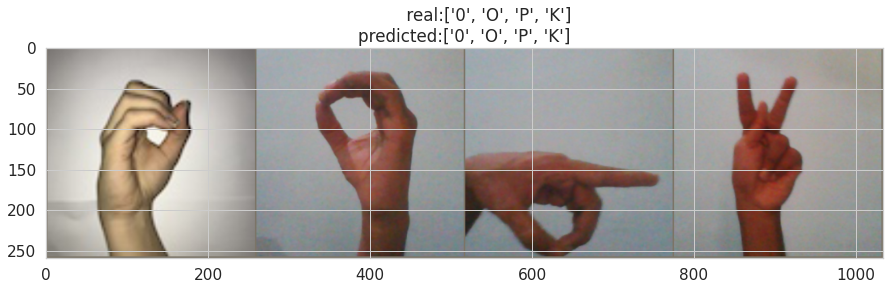

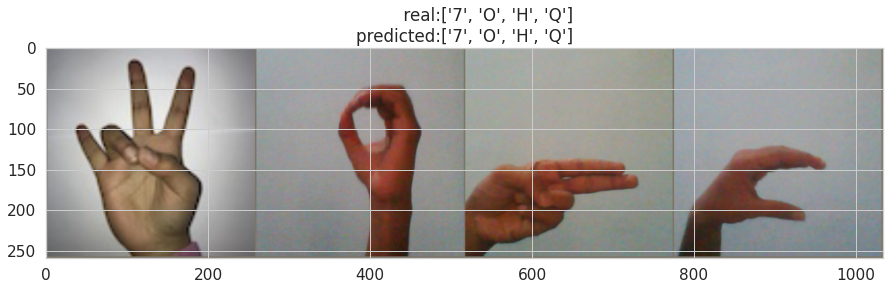

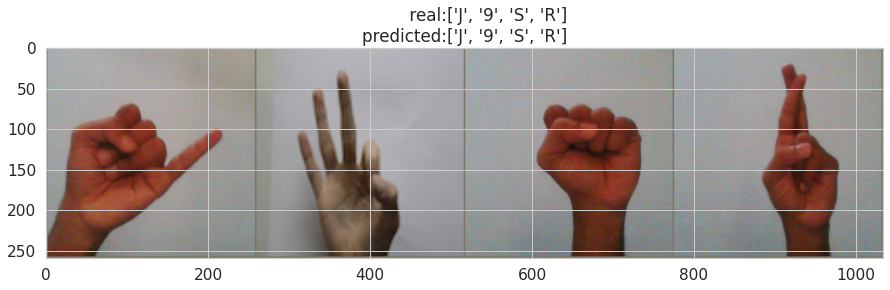

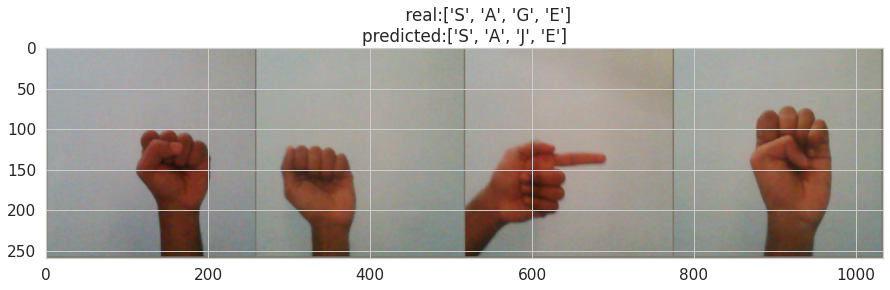

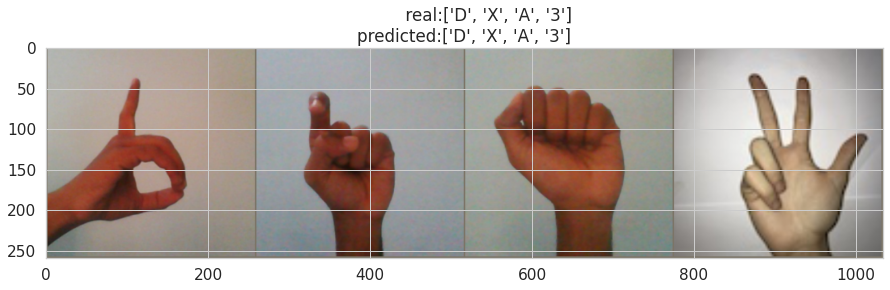

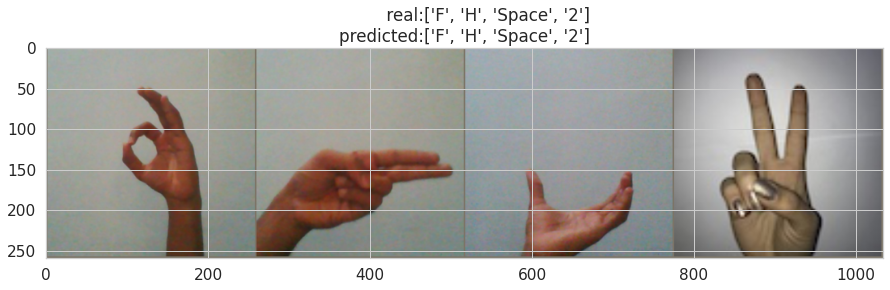

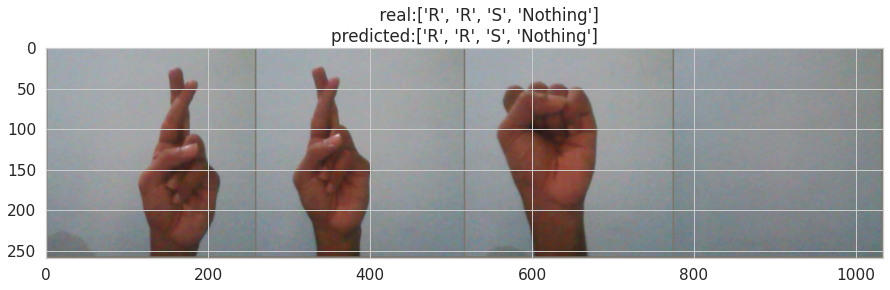

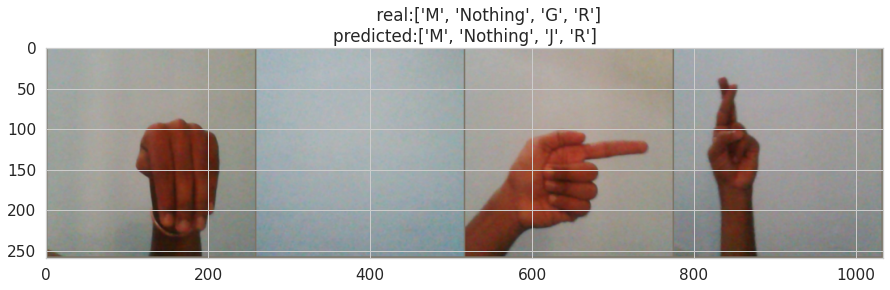

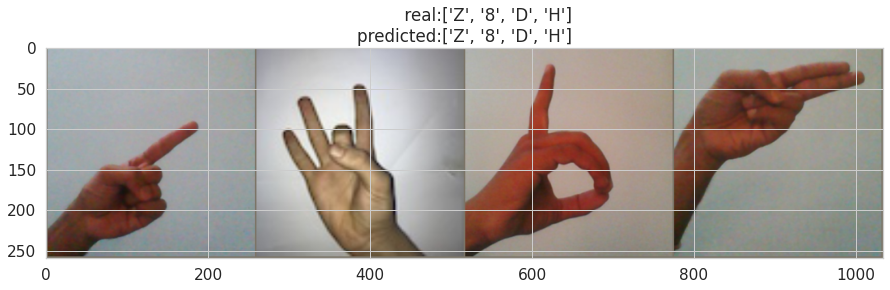

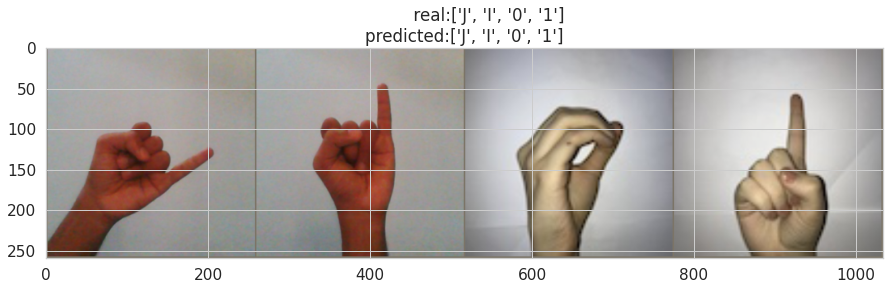

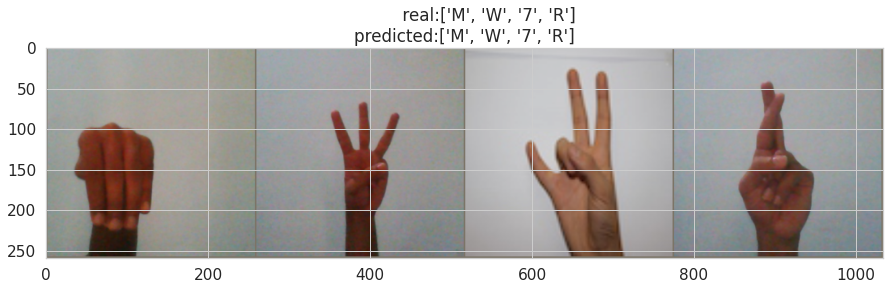

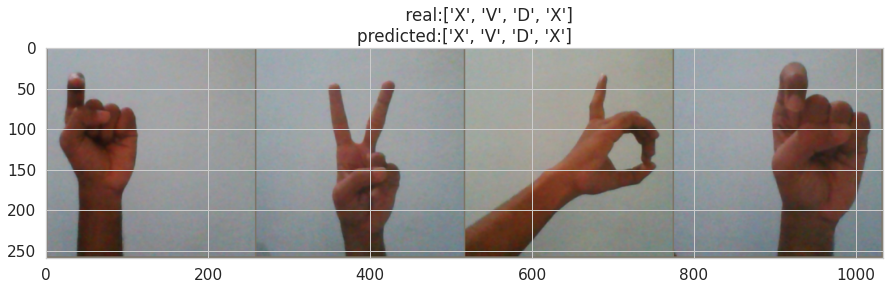

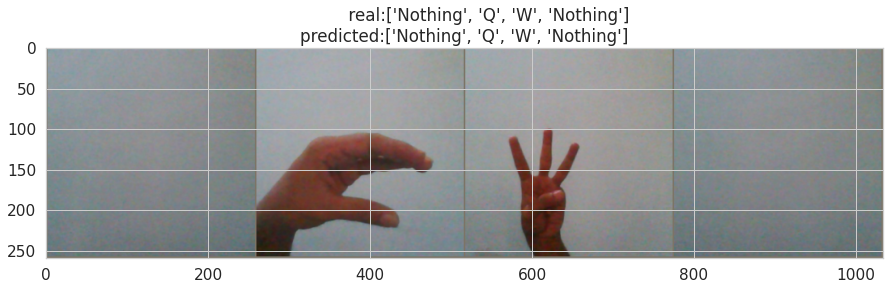

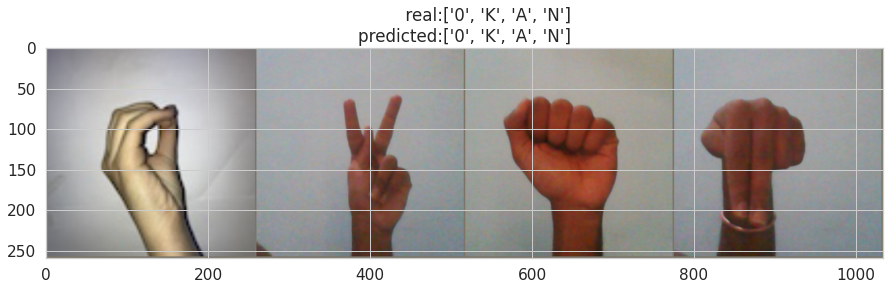

In [63]:
visualize_model(model_diff_lr, num_batches=20)